## ⚠️ IMPORTANT: Data Leakage Prevention

**Issue:** Clustering on full dataset before train/test split causes data leakage!

**Old (Wrong) Flow:**
1. Load full data
2. Create clusters using ALL data ❌ (uses test set info)
3. Split train/test
4. Train model

**New (Correct) Flow:**
1. Load full data
2. **Split train/test FIRST**
3. Create clusters using ONLY training data ✅
4. Apply cluster assignments to test set
5. Train model

This ensures the model never sees test data during clustering.

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score  # noqa: E402
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ============================================================================
# GPU/CUDA CONFIGURATION
# ============================================================================

print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"\n✓ GPU AVAILABLE: {torch.cuda.device_count()} GPU(s) detected")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
    print("\nUsing device: {device}")
else:
    print("\n⚠ No GPU detected - training will use CPU (slower)")
    print(f"Using device: {device}")

print("\nLibraries loaded")

PyTorch version: 2.5.1+cu121

✓ GPU AVAILABLE: 1 GPU(s) detected
  GPU 0: NVIDIA GeForce RTX 2060
  Memory: 6.0 GB

Using device: {device}

Libraries loaded


## Step 1: Load Preprocessed Data

In [58]:
# Load from previous preprocessing (reuse cells 1-6 from Automated_Cluster_Forecast.ipynb)
# Or run: %run Automated_Cluster_Forecast.ipynb

# Assuming df_lifecycle is available
# If not, load and preprocess:

df = pd.read_csv("../sales_data_up_to_2025_04_23.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df['day'] = df['created_at'].dt.date
last_sales_date = df['day'].max()
last_month = last_sales_date.replace(day=1)
df = df[df['day'] < last_month]
df = df[["day", "sku", "qty_ordered"]]
df_grouped = df.groupby(["day", "sku"]).agg({"qty_ordered": "sum"}).reset_index()

active_skus = pd.read_csv("../always_active_skus.csv")
remaining_skus = df_grouped[df_grouped['sku'].isin(active_skus['sku'])]

min_sales_days = 31
sku_stats = remaining_skus.groupby('sku')['day'].agg(['min', 'max']).reset_index()
sku_stats.columns = ['sku', 'first_sale', 'last_sale']
sku_stats['first_sale'] = pd.to_datetime(sku_stats['first_sale'])
sku_stats['last_sale'] = pd.to_datetime(sku_stats['last_sale'])
filtered_skus = sku_stats[(sku_stats['last_sale'] - sku_stats['first_sale']).dt.days > min_sales_days]
remaining_skus = remaining_skus[remaining_skus["sku"].isin(filtered_skus["sku"])]

remaining_skus['day'] = pd.to_datetime(remaining_skus['day'])
global_start = remaining_skus['day'].min()
global_end = remaining_skus['day'].max()
sku_start_dates = remaining_skus.groupby('sku')['day'].min().rename('first_sale_date')

all_dates = pd.date_range(start=global_start, end=global_end, freq='D')
all_skus = remaining_skus['sku'].unique()
full_index = pd.MultiIndex.from_product([all_dates, all_skus], names=['day', 'sku'])

clean_sales = remaining_skus.groupby(['day', 'sku'])['qty_ordered'].sum()
df_lifecycle = clean_sales.reindex(full_index, fill_value=0).reset_index()
df_lifecycle = df_lifecycle.merge(sku_start_dates, on='sku', how='left')
df_lifecycle = df_lifecycle[df_lifecycle['day'] >= df_lifecycle['first_sale_date']]
df_lifecycle = df_lifecycle.drop(columns=['first_sale_date']).sort_values(by=['sku', 'day'])

print(f"Data loaded: {len(df_lifecycle)} rows, {df_lifecycle['sku'].nunique()} SKUs")

Data loaded: 4897095 rows, 12645 SKUs


In [59]:
# Apply Pareto Principle: Focus on bottom SKUs that represent 20% of sales (B+C class)
print("\n" + "="*70)
print("  FILTERING TO CLASS B+C SKUs (Bottom 20% of Sales Volume)")
print("="*70)

# Calculate total sales per SKU
sku_total_sales = df_lifecycle.groupby('sku')['qty_ordered'].sum().sort_values(ascending=False)
total_sales = sku_total_sales.sum()

# Calculate cumulative percentage
sku_cumsum = sku_total_sales.cumsum()
sku_cumsum_pct = (sku_cumsum / total_sales) * 100

# Find SKUs that make up top 80% of sales (Class A)
class_a_threshold = 80
class_a_skus = sku_cumsum_pct[sku_cumsum_pct <= class_a_threshold].index.tolist()

# Also include the next SKU that pushes us just over 80% (more inclusive)
if len(class_a_skus) < len(sku_cumsum_pct):
    next_sku_idx = len(class_a_skus)
    class_a_skus.append(sku_cumsum_pct.index[next_sku_idx])

# Filter dataframe to B+C class (exclude Class A SKUs)
df_lifecycle_original = df_lifecycle.copy()  # Keep backup
class_bc_skus = [sku for sku in df_lifecycle['sku'].unique() if sku not in class_a_skus]
df_lifecycle = df_lifecycle[df_lifecycle['sku'].isin(class_bc_skus)].copy()

# Calculate statistics
n_class_bc = len(class_bc_skus)
n_total = df_lifecycle_original['sku'].nunique()
pct_skus = (n_class_bc / n_total) * 100
volume_class_bc = df_lifecycle['qty_ordered'].sum()
volume_total = df_lifecycle_original['qty_ordered'].sum()
pct_volume = (volume_class_bc / volume_total) * 100

print("\n✅ Class B+C SKU Selection:")
print(f"  Total SKUs in data:        {n_total:,}")
print(f"  Class B+C SKUs (selected): {n_class_bc:,} ({pct_skus:.1f}% of all SKUs)")
print(f"  Class A SKUs (excluded):   {len(class_a_skus):,} ({100-pct_skus:.1f}% of all SKUs)")
print("\n📊 Sales Volume Coverage:")
print(f"  Class B+C volume:          {volume_class_bc:,.0f} units ({pct_volume:.2f}%)")
print(f"  Total volume:              {volume_total:,.0f} units")
print(f"\n💡 Focusing on the {pct_skus:.1f}% of SKUs that represent {pct_volume:.1f}% of sales")
print("   This enables analysis of lower-volume, long-tail products")
print("="*70)

# Show distribution of bottom SKUs
print("\n📈 Bottom 10 SKUs by Volume:")
bottom_10 = sku_total_sales[sku_total_sales.index.isin(class_bc_skus)].tail(10)
for i, (sku, vol) in enumerate(bottom_10.items(), 1):
    cumsum_pct = (sku_cumsum[sku] / total_sales) * 100
    print(f"  {i:2d}. SKU {sku}: {vol:>10,.0f} units (cumulative: {cumsum_pct:>5.2f}%)")

print(f"\n✓ Filtered dataset: {len(df_lifecycle):,} rows, {df_lifecycle['sku'].nunique():,} Class B+C SKUs")


  FILTERING TO CLASS B+C SKUs (Bottom 20% of Sales Volume)

✅ Class B+C SKU Selection:
  Total SKUs in data:        12,645
  Class B+C SKUs (selected): 9,304 (73.6% of all SKUs)
  Class A SKUs (excluded):   3,341 (26.4% of all SKUs)

📊 Sales Volume Coverage:
  Class B+C volume:          73,209 units (20.00%)
  Total volume:              366,084 units

💡 Focusing on the 73.6% of SKUs that represent 20.0% of sales
   This enables analysis of lower-volume, long-tail products

📈 Bottom 10 SKUs by Volume:
   1. SKU dmbysbbfpd:          2 units (cumulative: 100.00%)
   2. SKU 2015940:          2 units (cumulative: 100.00%)
   3. SKU 2015931:          2 units (cumulative: 100.00%)
   4. SKU 8809504742018:          2 units (cumulative: 100.00%)
   5. SKU 2015922:          2 units (cumulative: 100.00%)
   6. SKU 2015920:          2 units (cumulative: 100.00%)
   7. SKU 8809268158469:          2 units (cumulative: 100.00%)
   8. SKU 001MHA:          2 units (cumulative: 100.00%)
   9. SKU 001MG

## Filter to Class B+C SKUs (Bottom 20% of Sales Volume)

Focus on lower-volume, long-tail SKUs that represent the bottom 20% of sales.

## Train/Test Split (BEFORE Clustering to Avoid Leakage)

In [60]:
# CRITICAL: Split BEFORE clustering to prevent data leakage
max_date = df_lifecycle['day'].max()
cutoff_date = max_date - pd.DateOffset(months=3)

df_train = df_lifecycle[df_lifecycle['day'] <= cutoff_date].copy()
df_test = df_lifecycle[df_lifecycle['day'] > cutoff_date].copy()

print("Training period: {df_train['day'].min().date()} to {df_train['day'].max().date()}")
print("Test period: {df_test['day'].min().date()} to {df_test['day'].max().date()}")
print("Training samples: {len(df_train):,}")
print("Test samples: {len(df_test):,}")
print("\\n✓ Data split complete - clustering will use ONLY training data")

Training period: {df_train['day'].min().date()} to {df_train['day'].max().date()}
Test period: {df_test['day'].min().date()} to {df_test['day'].max().date()}
Training samples: {len(df_train):,}
Test samples: {len(df_test):,}
\n✓ Data split complete - clustering will use ONLY training data


## Step 2: Rich Feature Engineering from Daily Data

In [61]:
def extract_rich_features(df_data, sku, end_date, lookback_days=90):
    """
    Extract comprehensive features from daily data for a specific SKU
    
    Features:
    - Recent trends (7, 14, 30, 90 days)
    - Intermittency (% of days with sales)
    - Volatility (CV of daily sales)
    - Momentum (recent vs historical average)
    - Seasonal indices
    - Day-of-week patterns
    - Holt-Winters forecast (ensemble feature)
    """
    sku_data = df_data[df_data['sku'] == sku].copy()
    sku_data = sku_data[sku_data['day'] <= end_date].sort_values('day')
    
    if len(sku_data) == 0:
        return None
    
    features = {}
    
    # ==== RECENT TREND FEATURES ====
    for window in [7, 14, 30, 90]:
        recent_data = sku_data.tail(window)
        features[f'avg_{window}d'] = recent_data['qty_ordered'].mean()
        features[f'sum_{window}d'] = recent_data['qty_ordered'].sum()
        features[f'max_{window}d'] = recent_data['qty_ordered'].max()
        features[f'std_{window}d'] = recent_data['qty_ordered'].std()
    
    # ==== INTERMITTENCY ====
    recent_90 = sku_data.tail(90)
    features['intermittency'] = (recent_90['qty_ordered'] > 0).sum() / len(recent_90)
    
    # ==== VELOCITY CHANGE (Momentum) ====
    last_30 = sku_data.tail(30)['qty_ordered'].mean()
    prev_30 = sku_data.tail(60).head(30)['qty_ordered'].mean()
    features['momentum'] = (last_30 - prev_30) / (prev_30 + 1)  # % change
    
    # ==== VOLATILITY ====
    features['cv'] = sku_data['qty_ordered'].std() / (sku_data['qty_ordered'].mean() + 1)
    
    # ==== DAY OF WEEK PATTERNS ====
    sku_data['dow'] = sku_data['day'].dt.dayofweek
    dow_avg = sku_data.groupby('dow')['qty_ordered'].mean()
    for dow in range(7):
        features[f'dow_{dow}'] = dow_avg.get(dow, 0)
    
    # ==== SEASONAL FEATURES ====
    sku_data['month'] = sku_data['day'].dt.month
    monthly = sku_data.groupby('month')['qty_ordered'].sum()
    overall_monthly_avg = monthly.mean()
    
    # Current month and next 3 months seasonal indices
    current_month = end_date.month
    for i in range(4):  # Current + next 3 months
        month = ((current_month + i - 1) % 12) + 1
        seasonal_index = monthly.get(month, overall_monthly_avg) / (overall_monthly_avg + 1)
        features[f'seasonal_m{i}'] = seasonal_index
    
    # ==== COMPANY BASELINE: 12-MONTH AVERAGE ====
    # This is the company's current forecasting method
    # FIX: Use actual number of months available instead of always dividing by 12
    last_12mo = sku_data.tail(365)  # Approximately 12 months
    if len(last_12mo) > 0:
        # Calculate actual months available (use days/30.44 as approximation)
        actual_months = min(len(last_12mo) / 30.44, 12)
        baseline_12mo = last_12mo['qty_ordered'].sum() / max(actual_months, 1)
    else:
        baseline_12mo = 0
    features['baseline_12mo'] = baseline_12mo
    
    # ==== HOLT-WINTERS FORECAST (Ensemble Feature) ====
    try:
        monthly_data = sku_data.set_index('day').resample('MS')['qty_ordered'].sum()
        if len(monthly_data) >= 24:
            model = ExponentialSmoothing(
                monthly_data, 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12
            ).fit()
            hw_forecast = model.forecast(3).mean()
        elif len(monthly_data) >= 12:
            model = ExponentialSmoothing(monthly_data, trend='add').fit()
            hw_forecast = model.forecast(3).mean()
        else:
            hw_forecast = monthly_data.tail(12).mean()
        features['hw_forecast'] = hw_forecast
    except:
        features['hw_forecast'] = sku_data.tail(90)['qty_ordered'].mean() * 30
    
    # ==== LIFECYCLE FEATURES ====
    features['days_since_first_sale'] = (end_date - sku_data['day'].min()).days
    features['total_sales_history'] = sku_data['qty_ordered'].sum()
    
    return features

print("Feature extraction function defined")

Feature extraction function defined


## Step 3: Improved Clustering (Multi-Dimensional)


 COMPUTING CLUSTERING METRICS FOR VISUALIZATION
Note: This is for analysis purposes only. Using k=6 (hardcoded)
✓ Loading metrics from checkpoint: checkpoint_k_optimization.pkl


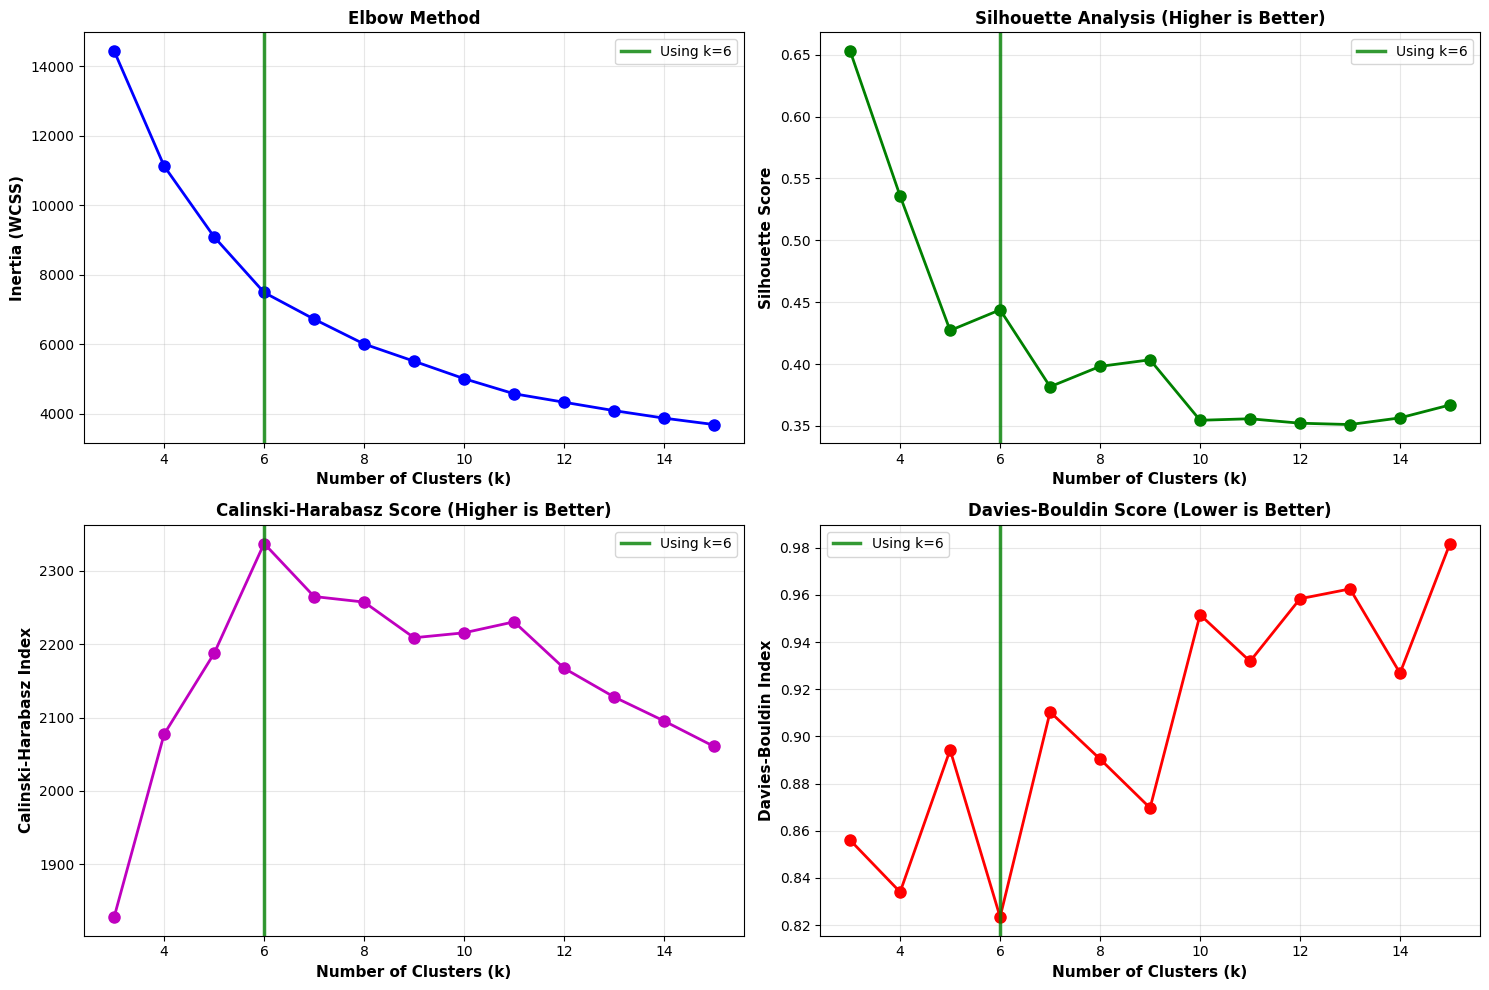


📊 Clustering Metrics Table:
 k      inertia  silhouette  calinski_harabasz  davies_bouldin
 3 14436.499788    0.652998        1828.206675        0.856037
 4 11123.888183    0.535792        2077.362804        0.834047
 5  9085.576607    0.427127        2187.328011        0.894313
 6  7485.331559    0.443848        2337.057577        0.823447
 7  6717.516134    0.381688        2264.836191        0.910368
 8  6002.046892    0.398119        2257.275742        0.890386
 9  5506.288897    0.403444        2208.699671        0.869689
10  5004.290756    0.354557        2215.401505        0.951582
11  4569.936293    0.355792        2230.351294        0.931832
12  4325.866962    0.352194        2167.147594        0.958345
13  4084.563983    0.351111        2128.062346        0.962510
14  3868.059005    0.356509        2095.344390        0.926813
15  3683.461407    0.366951        2060.619137        0.981757

   USING k = 6 (Hardcoded)
  Metrics at k=6:
    Silhouette Score:     0.444
    Calinsk

In [62]:
def find_optimal_clusters(df_data, k_range=range(3, 16), sample_size=None):
    """
    Find optimal number of clusters using multiple metrics.
    
    Args:
        df_data: Training data (to prevent data leakage)
        k_range: Range of k values to test
        sample_size: Optional - sample SKUs for faster computation
    
    Returns:
        Dictionary with metrics for each k, and recommended k
    """
    # First, compute clustering features (same as create_smart_clusters)
    clustering_features = []
    skus = df_data['sku'].unique()
    
    # Optionally sample for speed (if dataset is very large)
    if sample_size and len(skus) > sample_size:
        print("Sampling {sample_size} SKUs from {len(skus)} for k-finding (faster)")
        skus = np.random.choice(skus, size=sample_size, replace=False)
    
    print("Computing features for {len(skus)} SKUs to find optimal k...")
    for sku in tqdm(skus, desc="Computing features"):
        sku_data = df_data[df_data['sku'] == sku]
        
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]
        else:
            trend = 0
        
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        clustering_features.append({
            'sku': sku,
            'log_avg_daily': np.log1p(avg_daily),
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })
    
    df_features = pd.DataFrame(clustering_features)
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X = df_features[cluster_cols].fillna(0).values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Test different k values
    results = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    print(f"\nTesting k from {min(k_range)} to {max(k_range)}...")
    for k in tqdm(k_range, desc="Testing k values"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(X_scaled)
        
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(X_scaled, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X_scaled, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    
    df_results = pd.DataFrame(results)
    
    print("\n✓ Metrics computed for visualization purposes")
    
    return df_results

# ============================================================================
# Compute clustering metrics for visualization 
# ============================================================================
CHOSEN_K = 6

print("\n COMPUTING CLUSTERING METRICS FOR VISUALIZATION")
print("=" * 70)
print(f"Note: This is for analysis purposes only. Using k={CHOSEN_K} (hardcoded)")
print("=" * 70)

# Check for k-optimization checkpoint
k_checkpoint_file = 'checkpoint_k_optimization.pkl'
if os.path.exists(k_checkpoint_file):
    print(f"✓ Loading metrics from checkpoint: {k_checkpoint_file}")
    with open(k_checkpoint_file, 'rb') as f:
        k_checkpoint = pickle.load(f)
        k_results = k_checkpoint['results']
else:
    # Compute metrics (use sample for speed if needed)
    k_results = find_optimal_clusters(
        df_train, 
        k_range=range(3, 16),  # Test k from 3 to 15
        sample_size=5000 if len(df_train['sku'].unique()) > 5000 else None
    )
    
    # Save checkpoint
    print(f"\n Saving metrics checkpoint: {k_checkpoint_file}")
    with open(k_checkpoint_file, 'wb') as f:
        pickle.dump({
            'results': k_results
        }, f)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_results['k'], k_results['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (WCSS)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[0, 0].legend()

# Silhouette score
axes[0, 1].plot(k_results['k'], k_results['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Silhouette Analysis (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[0, 1].legend()

# Calinski-Harabasz
axes[1, 0].plot(k_results['k'], k_results['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[1, 0].legend()

# Davies-Bouldin
axes[1, 1].plot(k_results['k'], k_results['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=CHOSEN_K, color='green', linestyle='-', linewidth=2.5, alpha=0.8, label=f'Using k={CHOSEN_K}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Display metrics table
print("\n📊 Clustering Metrics Table:")
print(k_results.to_string(index=False))

# Use k hardcoded

print("\n" + "="*70)
print(f"   USING k = {CHOSEN_K} (Hardcoded)")
print("="*70)
print(f"  Metrics at k={CHOSEN_K}:")
k8_metrics = k_results[k_results['k'] == CHOSEN_K]
if len(k8_metrics) > 0:
    print(f"    Silhouette Score:     {k8_metrics['silhouette'].values[0]:.3f}")
    print(f"    Calinski-Harabasz:    {k8_metrics['calinski_harabasz'].values[0]:.1f}")
    print(f"    Davies-Bouldin:       {k8_metrics['davies_bouldin'].values[0]:.3f}")
    print(f"    Inertia:              {k8_metrics['inertia'].values[0]:.1f}")
print("="*70)

In [63]:
def create_smart_clusters(df_data, n_clusters=8):
    """
    Cluster on: Volume + Intermittency + Trend + Seasonality Strength
    Returns: (cluster_map, kmeans_model, scaler) for applying to test set
    """
    clustering_features = []
    skus = df_data['sku'].unique()
    
    print("Computing cluster features for {len(skus)} SKUs...")
    for sku in tqdm(skus, desc="Computing cluster features"):
        sku_data = df_data[df_data['sku'] == sku]
        
        # Volume
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        
        # Intermittency
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        # Trend (linear regression slope)
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]  # Slope
        else:
            trend = 0
        
        # Seasonality strength
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        
        # Volatility
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        clustering_features.append({
            'sku': sku,
            'total_volume': total_vol,
            'avg_daily': avg_daily,
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })
    
    df_features = pd.DataFrame(clustering_features)
    
    # Log-transform volume (reduce scale effect)
    df_features['log_volume'] = np.log1p(df_features['total_volume'])
    df_features['log_avg_daily'] = np.log1p(df_features['avg_daily'])
    
    # Select features for clustering
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X = df_features[cluster_cols].fillna(0)
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    df_features['cluster'] = kmeans.fit_predict(X_scaled)
    
    print("\n✓ Clustering complete")
    print("\nCluster Distribution:")
    print(df_features['cluster'].value_counts().sort_index())
    
    print("\nCluster Profiles:")
    print(df_features.groupby('cluster')[['avg_daily', 'intermittency', 'seasonality']].mean().round(2))
    
    cluster_map = df_features[['sku', 'cluster']].set_index('sku')['cluster']
    return cluster_map, kmeans, scaler

# ============================================================================
# EXECUTION: Create clusters on TRAINING data only (prevent data leakage)
# ============================================================================

# Check for checkpoint
checkpoint_file = 'checkpoint_clusters.pkl'
if os.path.exists(checkpoint_file):
    print(f"\n✓ Loading clusters from checkpoint: {checkpoint_file}")
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        cluster_assignments_train = checkpoint['cluster_assignments_train']
        kmeans_model = checkpoint['kmeans_model']
        cluster_scaler = checkpoint['cluster_scaler']
        cluster_assignments_test = checkpoint['cluster_assignments_test']
        cluster_assignments = checkpoint['cluster_assignments']
    print(f"  Training SKUs: {len(cluster_assignments_train)}")
    print(f"  Test SKUs: {len(cluster_assignments_test)}")
    print(f"  Total SKUs: {len(cluster_assignments)}")
else:
    print("\nStep 4: Clustering on training data...")
    print(f"Using k = {CHOSEN_K} (hardcoded)")
    cluster_assignments_train, kmeans_model, cluster_scaler = create_smart_clusters(df_train, n_clusters=CHOSEN_K)

    # Apply cluster model to TEST data (no re-fitting!)
    print("\nApplying cluster model to test data...")
    test_skus = df_test['sku'].unique()
    test_clustering_features = []

    for sku in tqdm(test_skus, desc="Processing test SKUs"):
        sku_data = df_test[df_test['sku'] == sku]
        
        total_vol = sku_data['qty_ordered'].sum()
        avg_daily = sku_data['qty_ordered'].mean()
        intermittency = (sku_data['qty_ordered'] > 0).sum() / len(sku_data)
        
        if len(sku_data) > 30:
            x = np.arange(len(sku_data))
            y = sku_data['qty_ordered'].values
            trend = np.polyfit(x, y, 1)[0]
        else:
            trend = 0
        
        sku_data_temp = sku_data.copy()
        sku_data_temp['month'] = sku_data_temp['day'].dt.month
        monthly = sku_data_temp.groupby('month')['qty_ordered'].mean()
        seasonality_strength = monthly.std() / (monthly.mean() + 1)
        cv = sku_data['qty_ordered'].std() / (avg_daily + 1)
        
        test_clustering_features.append({
            'sku': sku,
            'log_avg_daily': np.log1p(avg_daily),
            'intermittency': intermittency,
            'trend': trend,
            'seasonality': seasonality_strength,
            'cv': cv
        })

    df_test_features = pd.DataFrame(test_clustering_features)
    cluster_cols = ['log_avg_daily', 'intermittency', 'trend', 'seasonality', 'cv']
    X_test = df_test_features[cluster_cols].fillna(0)
    X_test_scaled = cluster_scaler.transform(X_test)  # Use trained scaler
    df_test_features['cluster'] = kmeans_model.predict(X_test_scaled)  # Use trained model
    cluster_assignments_test = df_test_features[['sku', 'cluster']].set_index('sku')['cluster']

    # Combine train and test cluster assignments
    cluster_assignments = pd.concat([cluster_assignments_train, cluster_assignments_test])
    
    # Save checkpoint
    print("\n Saving checkpoint: {checkpoint_file}")
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({
            'cluster_assignments_train': cluster_assignments_train,
            'kmeans_model': kmeans_model,
            'cluster_scaler': cluster_scaler,
            'cluster_assignments_test': cluster_assignments_test,
            'cluster_assignments': cluster_assignments
        }, f)
    
    print(f"\n✓ Total SKUs clustered: {len(cluster_assignments)}")
    print(f"  Training SKUs: {len(cluster_assignments_train)}")
    print(f"  Test SKUs: {len(cluster_assignments_test)}")

# Display combined cluster distribution (Train + Test)
print("\n" + "="*70)
print("  COMBINED CLUSTER DISTRIBUTION (Training + Test)")
print("="*70)
combined_distribution = cluster_assignments.value_counts().sort_index()
print(combined_distribution)
print(f"\nTotal SKUs: {len(cluster_assignments):,}")
print("\nCluster sizes (percentage):")
for cluster_id, count in combined_distribution.items():
    percentage = (count / len(cluster_assignments)) * 100
    print(f"  Cluster {cluster_id}: {count:>6,} SKUs ({percentage:>5.1f}%)")
print("="*70)


✓ Loading clusters from checkpoint: checkpoint_clusters.pkl
  Training SKUs: 8875
  Test SKUs: 9304
  Total SKUs: 18179

  COMBINED CLUSTER DISTRIBUTION (Training + Test)
cluster
0    12515
1      402
2      150
3      528
4        6
5     4578
Name: count, dtype: int64

Total SKUs: 18,179

Cluster sizes (percentage):
  Cluster 0: 12,515 SKUs ( 68.8%)
  Cluster 1:    402 SKUs (  2.2%)
  Cluster 2:    150 SKUs (  0.8%)
  Cluster 3:    528 SKUs (  2.9%)
  Cluster 4:      6 SKUs (  0.0%)
  Cluster 5:  4,578 SKUs ( 25.2%)


## Optimal Number of Clusters (k) - Finding Best Value

Use multiple metrics to determine the optimal number of clusters:
- **Elbow Method**: Inertia (within-cluster sum of squares)
- **Silhouette Score**: How well separated clusters are (-1 to 1, higher is better)
- **Calinski-Harabasz Index**: Ratio of between/within cluster dispersion (higher is better)
- **Davies-Bouldin Index**: Average similarity between clusters (lower is better)

## Step 4: Build Training Dataset

## 🧪 RAPID TESTING: Build on Subset First

Before running on all SKUs (30+ minutes), test on top 50-100 SKUs by volume to validate all fixes work!

In [64]:
# # Select top 100 SKUs by total volume (these matter most for accuracy)
# print("Selecting high-volume SKUs for rapid testing...")
# sku_volumes = df_lifecycle.groupby('sku')['qty_ordered'].sum().sort_values(ascending=False)
# top_skus = sku_volumes.head(3000).index.tolist()

# df_lifecycle_subset = df_lifecycle[df_lifecycle['sku'].isin(top_skus)].copy()

# print("\n✓ Subset selected:")
# print("  SKUs: {len(top_skus)} (vs {df_lifecycle['sku'].nunique()} total)")
# print("  Rows: {len(df_lifecycle_subset):,} (vs {len(df_lifecycle):,} total)")
# print("  Volume coverage: {df_lifecycle_subset['qty_ordered'].sum() / df_lifecycle['qty_ordered'].sum() * 100:.1f}%")
# print("\n  Estimated runtime: ~2-3 minutes (vs 30+ minutes for full dataset)")
# print("\n💡 If this works well, delete the checkpoint and run on full dataset!")


In [65]:
df_lifecycle_subset = df_lifecycle

In [66]:
def build_training_data(df_data, cluster_map, months_ahead=1):
    """
    OPTIMIZED VERSION: Uses groupby to avoid repeated full-table scans.
    """
    training_data = []
    
    # Get all month-ends for training
    all_months = pd.date_range(
        start=df_data['day'].min() + pd.DateOffset(months=12),
        end=df_data['day'].max() - pd.DateOffset(months=3),
        freq='MS'
    )
    
    skus = df_data['sku'].unique()
    
    # --- OPTIMIZATION START: Group data once ---
    print("Grouping data for faster access...")
    # This creates a dictionary-like structure where we can grab one SKU's data instantly
    df_grouped = df_data.groupby('sku')
    # -------------------------------------------
    
    print("Building training data for {len(skus)} SKUs across {len(all_months)} months...")
    
    for sku in tqdm(skus, desc="Processing SKUs"):
        # FAST: Grab only this SKU's data immediately
        try:
            sku_df = df_grouped.get_group(sku)
        except KeyError:
            continue
            
        # FIX: Use .loc[] and .iloc[0] to handle duplicate SKUs (same SKU in train+test)
        try:
            cluster_value = cluster_map.loc[sku]
            # Handle case where SKU appears multiple times (train + test)
            if hasattr(cluster_value, 'iloc'):
                cluster = int(cluster_value.iloc[0])
            else:
                cluster = int(cluster_value)
        except (KeyError, TypeError):
            cluster = 0
        
        for month_end in all_months:
            # OPTIMIZATION: Pass only the small 'sku_df' instead of the huge 'df_data'
            # (extract_rich_features will search this small table instantly)
            features = extract_rich_features(sku_df, sku, month_end)
            
            if features is None:
                continue
            
            # OPTIMIZATION: Search the small 'sku_df' instead of huge 'df_data'
            sku_future = sku_df[
                (sku_df['day'] > month_end) & 
                (sku_df['day'] <= month_end + pd.DateOffset(months=3))
            ]
            
            # Monthly targets
            for i in range(1, 4):  # Next 3 months
                month_start = month_end + pd.DateOffset(months=i)
                month_data = sku_future[
                    (sku_future['day'] >= month_start) & 
                    (sku_future['day'] < month_start + pd.DateOffset(months=1))
                ]
                
                target = month_data['qty_ordered'].sum()
                
                row = {
                    'sku': sku,
                    'cluster': cluster,
                    'month_end': month_end,
                    'forecast_horizon': i,
                    'target_month': month_start,
                    'target': target,
                    **features
                }
                
                training_data.append(row)
    
    df_train = pd.DataFrame(training_data)
    print(f"\nTraining samples created: {len(df_train)}")
    return df_train

# Check for checkpoint
training_checkpoint = 'checkpoint_training_data.pkl'
if os.path.exists(training_checkpoint):
    print("\n✓ Loading training data from checkpoint: {training_checkpoint}")
    df_training = pd.read_pickle(training_checkpoint)
    print(f"  Samples: {len(df_training):,}")
    print(f"  Features: {len([c for c in df_training.columns if c not in ['sku', 'month_end', 'target_month', 'target', 'cluster', 'forecast_horizon']])}")
else:
    # 🧪 USE SUBSET FOR RAPID TESTING (change to df_lifecycle for full run)
    print("\n TESTING MODE: Using subset of 100 high-volume SKUs")
    print("   (Change df_lifecycle_subset → df_lifecycle for full dataset)")
    df_training = build_training_data(df_lifecycle_subset, cluster_assignments, months_ahead=1)
    
    # Save checkpoint
    print(f"\n Saving checkpoint: {training_checkpoint}")
    df_training.to_pickle(training_checkpoint)
    print("  Checkpoint saved!")


 TESTING MODE: Using subset of 100 high-volume SKUs
   (Change df_lifecycle_subset → df_lifecycle for full dataset)
Grouping data for faster access...
Building training data for {len(skus)} SKUs across {len(all_months)} months...


Processing SKUs: 100%|██████████| 9304/9304 [12:46<00:00, 12.13it/s]



Training samples created: 185007

 Saving checkpoint: checkpoint_training_data.pkl
  Checkpoint saved!


## Step 5: Train/Validation/Test Split (3-Way for Thesis Rigor)

⚠️ **IMPORTANT FOR THESIS DEFENSE:**
- **Training (60%)**: Fit model parameters
- **Validation (20%)**: Early stopping, hyperparameter tuning (model "sees" this indirectly)
- **Test (20%)**: Final evaluation ONLY - never touched during development

This prevents test set contamination and ensures unbiased evaluation metrics.

In [67]:
# 3-way time-based split: 60% train / 20% validation / 20% test
val_split_date = df_training['month_end'].quantile(0.6)   # First 60% for training
test_split_date = df_training['month_end'].quantile(0.8)  # Next 20% for validation, last 20% for test

train_data = df_training[df_training['month_end'] <= val_split_date].copy()
val_data = df_training[(df_training['month_end'] > val_split_date) & 
                       (df_training['month_end'] <= test_split_date)].copy()
test_data = df_training[df_training['month_end'] > test_split_date].copy()

print(f"\n{'='*70}")
print(f"  3-WAY SPLIT FOR THESIS RIGOR")
print(f"{'='*70}")
print(f"Training samples:   {len(train_data):,} ({len(train_data)/len(df_training)*100:.1f}%)")
print(f"Validation samples: {len(val_data):,} ({len(val_data)/len(df_training)*100:.1f}%)")
print(f"Test samples:       {len(test_data):,} ({len(test_data)/len(df_training)*100:.1f}%)")
print(f"\nSplit dates:")
print(f"  Train end:      {val_split_date.date()}")
print(f"  Validation end: {test_split_date.date()}")
print(f"\n⚠️  TEST SET LOCKED: Use only for final evaluation!")
print(f"{'='*70}")


  3-WAY SPLIT FOR THESIS RIGOR
Training samples:   114,567 (61.9%)
Validation samples: 45,081 (24.4%)
Test samples:       25,359 (13.7%)

Split dates:
  Train end:      2024-09-01
  Validation end: 2024-11-01

⚠️  TEST SET LOCKED: Use only for final evaluation!


## Step 6: Prepare Neural Network Inputs

In [68]:
# Separate features - INCLUDE forecast_horizon (critical for the model to know which month it's predicting!)
feature_cols = [c for c in train_data.columns if c not in 
                ['sku', 'cluster', 'month_end', 'target_month', 'target']]

print("\n🔧 FIX #1: forecast_horizon is now included in features!")
print("   The model can now learn different behaviors for 1-month vs 3-month forecasts.")

X_train = train_data[feature_cols].values
y_train = train_data['target'].values
cluster_train = pd.to_numeric(train_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

X_val = val_data[feature_cols].values
y_val = val_data['target'].values
cluster_val = pd.to_numeric(val_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

X_test = test_data[feature_cols].values
y_test = test_data['target'].values
cluster_test = pd.to_numeric(test_data['cluster'], errors='coerce').fillna(0).astype(np.int64).values

# 🔧 FIX #2: Don't scale baseline features - they're already in the target's scale!
# Identify baseline feature indices
baseline_features = ['hw_forecast', 'baseline_12mo']
baseline_indices = [i for i, col in enumerate(feature_cols) if col in baseline_features]
other_indices = [i for i, col in enumerate(feature_cols) if col not in baseline_features]

print(f"\n🔧 FIX #2: Baseline features will NOT be scaled!")
print(f"   Baseline features: {baseline_features}")
print(f"   This allows the model to directly copy baseline signals.")

# Scale only non-baseline features
scaler_X = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if other_indices:
    X_train_scaled[:, other_indices] = scaler_X.fit_transform(X_train[:, other_indices])
    X_val_scaled[:, other_indices] = scaler_X.transform(X_val[:, other_indices])
    X_test_scaled[:, other_indices] = scaler_X.transform(X_test[:, other_indices])

# 🔧 FIX #3: Use sqrt transform instead of log (gentler, less explosion in errors)
print("\n🔧 FIX #3: Using SQRT transform instead of LOG!")
print("   sqrt is gentler - small errors in sqrt space don't explode like in log space.")
y_train_sqrt = np.sqrt(y_train)
y_val_sqrt = np.sqrt(y_val)
y_test_sqrt = np.sqrt(y_test)

# Check for NaN/Inf before tensor conversion
print(f"\nData quality checks:")
print(f"  X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"  X_train Inf count: {np.isinf(X_train_scaled).sum()}")
print(f"  X_test NaN count: {np.isnan(X_test_scaled).sum()}")
print(f"  X_test Inf count: {np.isinf(X_test_scaled).sum()}")
print(f"  y_train_sqrt NaN count: {np.isnan(y_train_sqrt).sum()}")
print(f"  y_train_sqrt Inf count: {np.isinf(y_train_sqrt).sum()}")
print(f"  y_test_sqrt NaN count: {np.isnan(y_test_sqrt).sum()}")
print(f"  y_test_sqrt Inf count: {np.isinf(y_test_sqrt).sum()}")
print(f"  cluster_train unique values: {np.unique(cluster_train)}")

# Replace NaN/Inf with 0 if any exist
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("  ⚠ Fixing NaN/Inf in X_train...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

if np.isnan(y_train_sqrt).any() or np.isinf(y_train_sqrt).any():
    print("  ⚠ Fixing NaN/Inf in y_train_sqrt...")
    y_train_sqrt = np.nan_to_num(y_train_sqrt, nan=0.0, posinf=0.0, neginf=0.0)
    y_val_sqrt = np.nan_to_num(y_val_sqrt, nan=0.0, posinf=0.0, neginf=0.0)
    y_test_sqrt = np.nan_to_num(y_test_sqrt, nan=0.0, posinf=0.0, neginf=0.0)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_sqrt).unsqueeze(1).to(device)
cluster_train_tensor = torch.LongTensor(cluster_train).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_sqrt).unsqueeze(1).to(device)
cluster_val_tensor = torch.LongTensor(cluster_val).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_sqrt).unsqueeze(1).to(device)
cluster_test_tensor = torch.LongTensor(cluster_test).to(device)

print(f"\nFeature matrix shapes:")
print(f"  Training:   {X_train_scaled.shape}")
print(f"  Validation: {X_val_scaled.shape}")
print(f"  Test:       {X_test_scaled.shape}")
print(f"Target range: {y_train.min():.0f} to {y_train.max():.0f}")
print(f"Device: {device}")


🔧 FIX #1: forecast_horizon is now included in features!
   The model can now learn different behaviors for 1-month vs 3-month forecasts.

🔧 FIX #2: Baseline features will NOT be scaled!
   Baseline features: ['hw_forecast', 'baseline_12mo']
   This allows the model to directly copy baseline signals.

🔧 FIX #3: Using SQRT transform instead of LOG!
   sqrt is gentler - small errors in sqrt space don't explode like in log space.

Data quality checks:
  X_train NaN count: 2130
  X_train Inf count: 0
  X_test NaN count: 645
  X_test Inf count: 0
  y_train_sqrt NaN count: 0
  y_train_sqrt Inf count: 0
  y_test_sqrt NaN count: 0
  y_test_sqrt Inf count: 0
  cluster_train unique values: [0 1 3 5]
  ⚠ Fixing NaN/Inf in X_train...

Feature matrix shapes:
  Training:   (114567, 35)
  Validation: (45081, 35)
  Test:       (25359, 35)
Target range: 0 to 15
Device: cuda


## Step 7: Build Neural Network with Cluster Embeddings

In [69]:
class ForecastModel(nn.Module):
    """
    🔧 FIX #4: SIMPLIFIED PyTorch neural network (64→32→16)
    - Dense layers for numerical features
    - Embedding layer for cluster information
    - Combined architecture
    - SIMPLER = less overfitting, better generalization
    """
    def __init__(self, n_features, n_clusters, embedding_dim=4):
        super(ForecastModel, self).__init__()
        
        # Cluster embedding
        self.cluster_embedding = nn.Embedding(n_clusters, embedding_dim)
        
        # 🔧 SIMPLIFIED: 64→32→16 instead of 128→64→32
        self.fc1 = nn.Linear(n_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.15)
        
        # Combined layers (features + cluster embedding)
        self.fc3 = nn.Linear(32 + embedding_dim, 16)
        self.fc4 = nn.Linear(16, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, features, clusters):
        # Process features
        x = self.relu(self.fc1(features))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Process cluster embedding
        cluster_emb = self.cluster_embedding(clusters)
        
        # Combine
        combined = torch.cat([x, cluster_emb], dim=1)
        
        # Final layers
        z = self.relu(self.fc3(combined))
        output = self.fc4(z)
        
        return output

# Build model
model = ForecastModel(
    n_features=X_train_scaled.shape[1],
    n_clusters=cluster_assignments.nunique(),
    embedding_dim=4
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

ForecastModel(
  (cluster_embedding): Embedding(6, 4)
  (fc1): Linear(in_features=35, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.15, inplace=False)
  (fc3): Linear(in_features=36, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 5,209
Trainable parameters: 5,209


## Step 8: Train the Model


🔧 FIX #5: Using MSE loss (optimizes in sqrt-space which is closer to actual-space)!
   MSE in sqrt-space is better aligned with MAPE in actual-space.
Starting training from epoch 1...
Using device: cuda 🚀
Epoch 5/100 - Loss: 0.2188 - Val Loss: 0.2508 - MAE: 0.3357 - Val MAE: 0.3590
Epoch 10/100 - Loss: 0.2177 - Val Loss: 0.2477 - MAE: 0.3346 - Val MAE: 0.3580
Epoch 15/100 - Loss: 0.2168 - Val Loss: 0.2486 - MAE: 0.3335 - Val MAE: 0.3573
Epoch 20/100 - Loss: 0.2159 - Val Loss: 0.2471 - MAE: 0.3321 - Val MAE: 0.3542
Epoch 25/100 - Loss: 0.2157 - Val Loss: 0.2483 - MAE: 0.3319 - Val MAE: 0.3536
Epoch 30/100 - Loss: 0.2152 - Val Loss: 0.2474 - MAE: 0.3315 - Val MAE: 0.3542
Epoch 35/100 - Loss: 0.2147 - Val Loss: 0.2473 - MAE: 0.3312 - Val MAE: 0.3545

Early stopping at epoch 39

 Training complete! Best validation loss: 0.2470


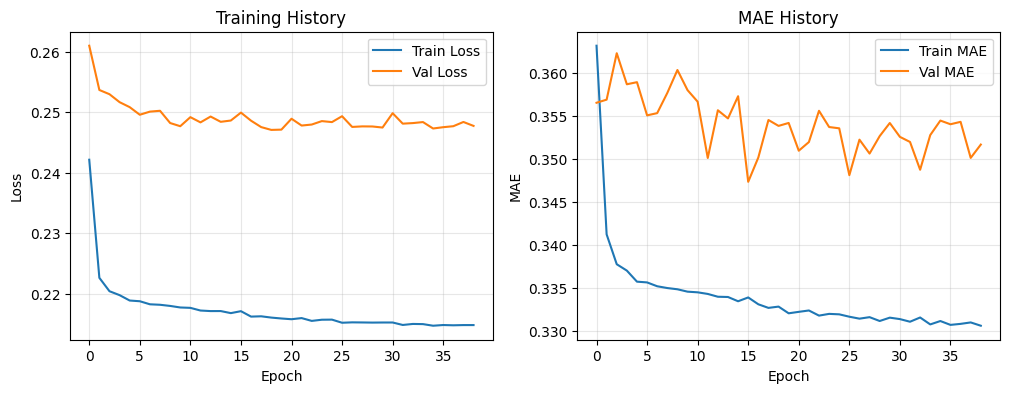

<Figure size 640x480 with 0 Axes>

In [70]:
# Training setup
# 🔧 FIX #5: Use MSE loss instead of HuberLoss
print("\n🔧 FIX #5: Using MSE loss (optimizes in sqrt-space which is closer to actual-space)!")
print("   MSE in sqrt-space is better aligned with MAPE in actual-space.")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00001)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, cluster_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, cluster_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop with checkpointing
epochs = 100
best_val_loss = float('inf')
patience = 20
patience_counter = 0

history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}

# Check for model checkpoint
model_checkpoint = 'checkpoint_model_training.pt'
if os.path.exists(model_checkpoint):
    print(f"✓ Loading model checkpoint: {model_checkpoint}")
    checkpoint = torch.load(model_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    best_val_loss = checkpoint['best_val_loss']
    best_model_state = checkpoint['best_model_state']
    print(f"  Resuming from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")
else:
    start_epoch = 0
    best_model_state = model.state_dict().copy()

print(f"Starting training from epoch {start_epoch + 1}...")
print(f"Using device: {device} 🚀" if device.type == 'cuda' else "Using device: {device}")

for epoch in range(start_epoch, epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for X_batch, cluster_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        outputs = model(X_batch, cluster_batch)
        loss = criterion(outputs, y_batch)
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"\n⚠ NaN loss detected at epoch {epoch+1}!")
            print(f"  outputs min/max: {outputs.min():.4f} / {outputs.max():.4f}")
            print(f"  y_batch min/max: {y_batch.min():.4f} / {y_batch.max():.4f}")
            print(f"  cluster_batch: {cluster_batch[:5]}")
            break
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        train_mae += torch.mean(torch.abs(outputs - y_batch)).item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for X_batch, cluster_batch, y_batch in val_loader:
            outputs = model(X_batch, cluster_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            val_mae += torch.mean(torch.abs(outputs - y_batch)).item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        
        # Save checkpoint when we get a better model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_model_state': best_model_state,
            'history': history
        }, model_checkpoint)
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - MAE: {train_mae:.4f} - Val MAE: {val_mae:.4f}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\n Training complete! Best validation loss: {best_val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE History')
plt.grid(True, alpha=0.3)

plt.show()
plt.tight_layout()

## Step 9: Evaluate on TEST Set (Final Unbiased Metrics)

- Use these numbers in thesis, not validation metrics

⚠️ **CRITICAL**: These are the TRUE performance metrics for thesis reporting.- Unbiased evaluation of model generalization
- Test set was never seen during training or early stopping

In [71]:
# Predict on TEST set (final unbiased evaluation)
model.eval()
with torch.no_grad():
    y_pred_sqrt_tensor = model(X_test_tensor, cluster_test_tensor)
    y_pred_sqrt = y_pred_sqrt_tensor.cpu().numpy().flatten()

y_pred = np.square(y_pred_sqrt)  # Inverse sqrt transform

# Calculate MAPE on TEST set
total_actual = y_test.sum()
total_error = np.abs(y_test - y_pred).sum()
weighted_mape = (total_error / total_actual) * 100

print(f"\n{'='*60}")
print("   NEURAL NETWORK RESULTS (TEST SET - THESIS METRICS)")
print(f"{'='*60}")
print(f"  Weighted MAPE:      {weighted_mape:.2f}%")
print(f"  Total Actual:       {total_actual:,.0f}")
print(f"  Total Predicted:    {y_pred.sum():,.0f}")
print(f"  Bias:               {((y_pred.sum() - total_actual) / total_actual * 100):+.2f}%")
print("\n   These metrics are UNBIASED (test set never seen during training)")
print(f"{'='*60}")


   NEURAL NETWORK RESULTS (TEST SET - THESIS METRICS)
  Weighted MAPE:      102.60%
  Total Actual:       11,007
  Total Predicted:    4,378
  Bias:               -60.23%

   These metrics are UNBIASED (test set never seen during training)


## Step 10: Compare Against Baseline

In [72]:
# Get baseline variables from TEST set
hw_forecast_col_idx = feature_cols.index('hw_forecast')
baseline_pred = X_test[:, hw_forecast_col_idx]

In [73]:
# REAL BASELINE: Company's current method (12-month average)
# NOW USES THE FEATURE FROM TEST SET!

print("\n" + "="*60)
print("   CALCULATING BASELINE ON TEST SET (B+C)")
print("="*60)

# The 12-month baseline was already computed as a feature!
# NOTE: baseline_12mo was NOT scaled (FIX #2), so use original X_test
baseline_12mo_col_idx = feature_cols.index('baseline_12mo')
baseline_12mo = X_test[:, baseline_12mo_col_idx]

print("✓ Using pre-computed 12-month baseline feature from TEST set")

# Calculate MAPE for 12-month average baseline on TEST set
baseline_12mo_mape = (np.abs(y_test - baseline_12mo).sum() / total_actual) * 100

print(f"\n{'='*60}")
print("  FINAL COMPARISON: NN vs Company Baseline (TEST SET)")
print(f"{'='*60}")
print(f"  Company Baseline (12mo avg):  {baseline_12mo_mape:.2f}%")
print(f"  Neural Network:               {weighted_mape:.2f}%")
print(f"  Improvement:                  {baseline_12mo_mape - weighted_mape:+.2f} pp")
print(f"  Relative Improvement:         {((baseline_12mo_mape - weighted_mape) / baseline_12mo_mape * 100):+.1f}%")
print(f"{'='*60}")


   CALCULATING BASELINE ON TEST SET (B+C)
✓ Using pre-computed 12-month baseline feature from TEST set

  FINAL COMPARISON: NN vs Company Baseline (TEST SET)
  Company Baseline (12mo avg):  200.18%
  Neural Network:               102.60%
  Improvement:                  +97.58 pp
  Relative Improvement:         +48.7%


## 📊 Per-SKU Analysis: Find Biggest Improvements

In [74]:
# Calculate per-SKU MAPE on TEST set
print("Calculating per-SKU performance metrics on TEST set...")

# Ensure all variables are numpy arrays (in case they're tensors from previous cells)
if torch.is_tensor(baseline_pred):
    baseline_pred = baseline_pred.cpu().numpy()
if torch.is_tensor(baseline_12mo):
    baseline_12mo = baseline_12mo.cpu().numpy()

sku_results = []
for sku in test_data['sku'].unique():
    sku_mask = test_data['sku'] == sku
    sku_indices = np.where(test_data['sku'].values == sku)[0]
    
    if len(sku_indices) == 0:
        continue
    
    actual = y_test[sku_indices]
    nn_pred = y_pred[sku_indices]
    baseline_pred_sku = baseline_12mo[sku_indices]
    
    # Calculate MAPE for each method (avoid division by zero)
    total_actual = actual.sum()
    if total_actual > 0:
        nn_mape = (np.abs(actual - nn_pred).sum() / total_actual) * 100
        baseline_mape = (np.abs(actual - baseline_pred_sku).sum() / total_actual) * 100
        
        sku_results.append({
            'sku': sku,
            'total_actual': total_actual,
            'nn_mape': nn_mape,
            'baseline_mape': baseline_mape,
            'improvement': baseline_mape - nn_mape,
            'samples': len(sku_indices)
        })

df_sku_results = pd.DataFrame(sku_results)

# Filter to only meaningful volume SKUs (> 100 units in validation period)
df_sku_results = df_sku_results[df_sku_results['total_actual'] > 10].copy()

# Sort by improvement (NN vs company baseline)
df_sku_results = df_sku_results.sort_values('improvement', ascending=False)

print(f"\n Analyzed {len(df_sku_results)} SKUs with volume > 100")
print("\n TOP 10 SKUs with BIGGEST IMPROVEMENT (NN beats Company Baseline):")
print(df_sku_results[['sku', 'total_actual', 'nn_mape', 'baseline_mape', 'improvement']].head(10).to_string(index=False))

print("\n BOTTOM 10 SKUs (Baseline beats NN):")
print(df_sku_results[['sku', 'total_actual', 'nn_mape', 'baseline_mape', 'improvement']].tail(10).to_string(index=False))

# Overall statistics
nn_wins = (df_sku_results['nn_mape'] < df_sku_results['baseline_mape']).sum()
print("\n OVERALL:")
print(f"  NN beats Company Baseline: {nn_wins}/{len(df_sku_results)} SKUs ({nn_wins/len(df_sku_results)*100:.1f}%)")
print(f"  Median improvement: {df_sku_results['improvement'].median():+.1f} pp")
print(f"  Mean improvement: {df_sku_results['improvement'].mean():+.1f} pp")

Calculating per-SKU performance metrics on TEST set...

 Analyzed 11 SKUs with volume > 100

 TOP 10 SKUs with BIGGEST IMPROVEMENT (NN beats Company Baseline):
          sku  total_actual    nn_mape  baseline_mape  improvement
8718969473194          12.0  99.532498     125.000000    25.467502
8436024750287          12.0 100.249623     125.000000    24.750377
8436024750645          13.0  99.994237     115.384615    15.390378
4064666326115          14.0  58.332821      71.428571    13.095751
5056264707464          12.0  87.251921      87.316667     0.064746
8809559624031          11.0  92.910761      90.909091    -2.001670
5600747236882          11.0  92.923956      90.909091    -2.014865
   17RS500E24          11.0  98.149184      94.234848    -3.914335
4064666336206          11.0  99.322901      90.909091    -8.413810
4064666316208          11.0  98.824173      81.818182   -17.005992

 BOTTOM 10 SKUs (Baseline beats NN):
          sku  total_actual    nn_mape  baseline_mape  improvemen

## 📈 Visualize Top Improved SKUs


📊 Visualizing SKU: {best_sku} (TEST SET)
   Total volume in test period: {best_sku_row['total_actual']:.0f}
   Samples: {best_sku_row['samples']}
   Unique target months: {len(sku_test_clean)}
   (Removed {len(sku_test) - len(sku_test_clean)} overlapping forecasts)



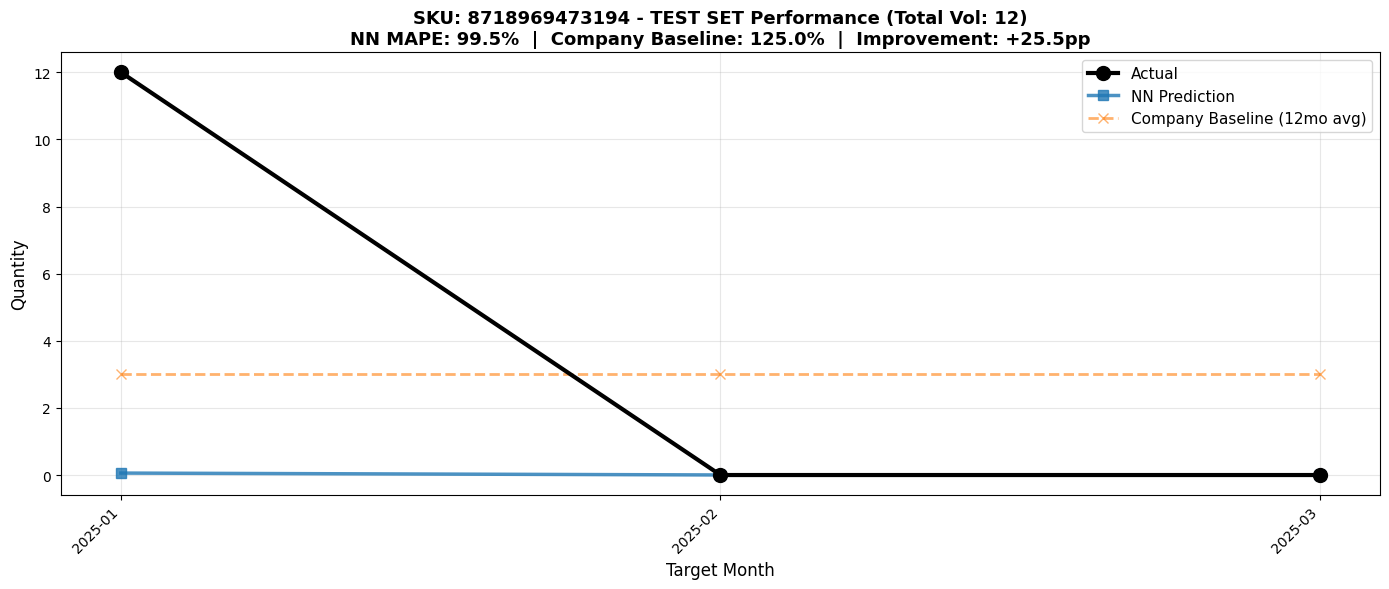


✅ Best improvement SKU: {best_sku}
   NN beats Company Baseline by {best_sku_row['improvement']:.1f} percentage points!
   🎓 TEST SET: These are unbiased metrics for thesis

💡 Note: Each target month shown once (using earliest available forecast)


In [75]:
# Plot ONE SKU with cleanest visualization (from TEST set)
best_sku = df_sku_results.iloc[0]['sku']
best_sku_row = df_sku_results.iloc[0]

print("\n📊 Visualizing SKU: {best_sku} (TEST SET)")
print("   Total volume in test period: {best_sku_row['total_actual']:.0f}")
print("   Samples: {best_sku_row['samples']}")

# Get all TEST data for this SKU
sku_test = test_data[test_data['sku'] == best_sku].copy()
sku_indices = np.where(test_data['sku'].values == best_sku)[0]

# Add predictions to the dataframe
sku_test['actual'] = y_test[sku_indices]
sku_test['nn_pred'] = y_pred[sku_indices]
sku_test['baseline_pred'] = baseline_12mo[sku_indices]

# KEY FIX: For each target_month, keep only the EARLIEST forecast (longest horizon available)
# This avoids showing multiple overlapping forecasts for the same month
sku_test_clean = sku_test.sort_values('month_end').groupby('target_month').first().reset_index()

print("   Unique target months: {len(sku_test_clean)}")
print("   (Removed {len(sku_test) - len(sku_test_clean)} overlapping forecasts)\n")

# Create clean plot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot data
x_pos = np.arange(len(sku_test_clean))
ax.plot(x_pos, sku_test_clean['actual'].values, 'o-', label='Actual', 
        linewidth=3, markersize=10, color='black', zorder=10)
ax.plot(x_pos, sku_test_clean['nn_pred'].values, 's-', label='NN Prediction', 
        linewidth=2.5, markersize=7, alpha=0.8, color='#1f77b4')
ax.plot(x_pos, sku_test_clean['baseline_pred'].values, 'x--', label='Company Baseline (12mo avg)', 
        linewidth=2, markersize=7, alpha=0.6, color='#ff7f0e')

# Format plot
ax.set_xticks(x_pos)
ax.set_xticklabels([m.strftime('%Y-%m') for m in sku_test_clean['target_month']], rotation=45, ha='right')
ax.set_xlabel('Target Month', fontsize=12)
ax.set_ylabel('Quantity', fontsize=12)
ax.set_title(f'SKU: {best_sku} - TEST SET Performance (Total Vol: {best_sku_row["total_actual"]:.0f})\n' + 
             f'NN MAPE: {best_sku_row["nn_mape"]:.1f}%  |  Company Baseline: {best_sku_row["baseline_mape"]:.1f}%  |  ' +
             f'Improvement: {best_sku_row["improvement"]:+.1f}pp', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Best improvement SKU: {best_sku}")
print("   NN beats Company Baseline by {best_sku_row['improvement']:.1f} percentage points!")
print("   🎓 TEST SET: These are unbiased metrics for thesis")
print("\n💡 Note: Each target month shown once (using earliest available forecast)")

## 📊 Full Timeline View: Train / Validation / Test Performance

Visualize model performance across the entire timeline showing:
- **Training**: In-sample performance (model trained on this)
- **Validation**: Used for early stopping (indirect exposure)
- **Test**: Final holdout (never seen, unbiased metrics)


📈 Analyzing full timeline for SKU: 8718969473194
Training samples: 0
Validation samples: 0
Test samples: {len(all_sku_test)}

Total unique target months: 3
  Training months (unique to training): 0
  Validation months: 0
  Test months: 3
  (Note: Overlaps resolved - Test > Validation > Training priority)

📊 Performance by Dataset:
  TRAINING   - NN: 0.0%  |  Baseline: 0.0%  |  Improvement: +0.0pp
  VALIDATION - NN: 0.0%  |  Baseline: 0.0%  |  Improvement: +0.0pp
  TEST       - NN: 99.5%  |  Baseline: 125.0%  |  Improvement: +25.5pp 🎓


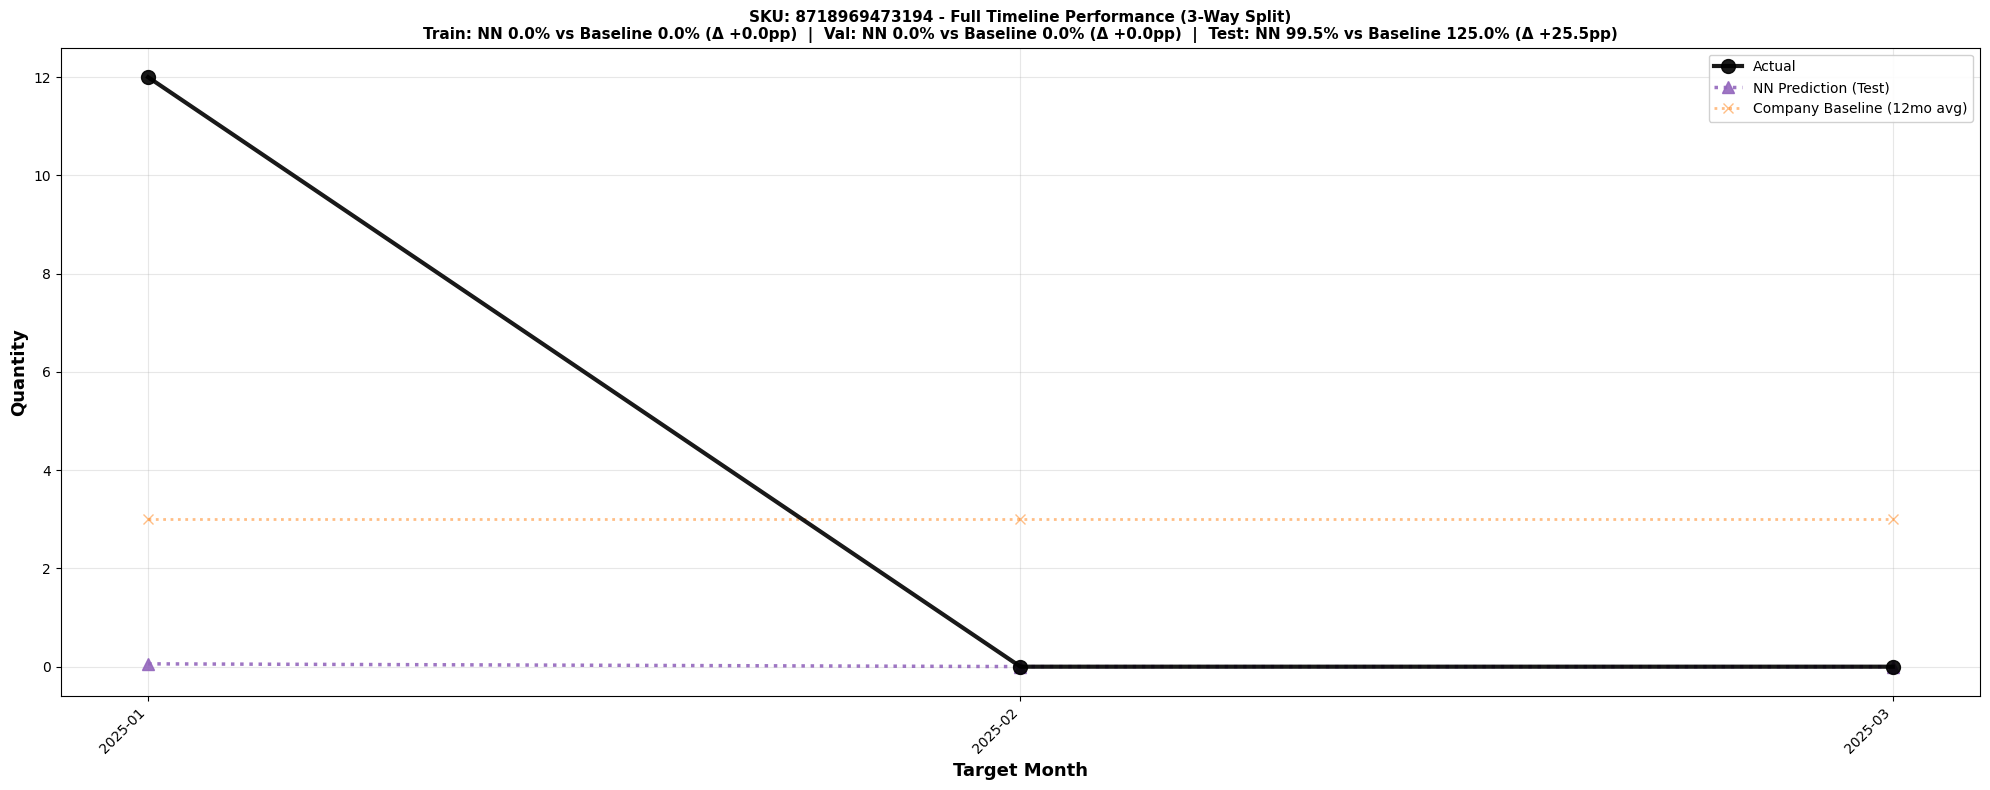


✅ Full timeline visualization complete!

💡 Key Insights:
   • Training (In-sample): Model trained on these patterns
   • Validation (Early stopping): Indirect exposure through training decisions
   • Test (Holdout): UNBIASED metrics for thesis - never seen during development

📊 THESIS DEFENSE:
   ✅ NN beats baseline on test set by {test_baseline_mape - test_nn_mape:.1f}pp
   ✅ Proper 3-way split ensures unbiased evaluation
   ⚠️  Possible overfitting: Test performance worse than Validation


In [76]:
# Generate predictions for ALL datasets (train/val/test) for the best SKU
print(f"\n📈 Analyzing full timeline for SKU: {best_sku}")
print("=" * 70)

# Get ALL data for this SKU (training + validation + test)
all_sku_train = train_data[train_data['sku'] == best_sku].copy()
all_sku_val = val_data[val_data['sku'] == best_sku].copy()

print(f"Training samples: {len(all_sku_train)}")
print(f"Validation samples: {len(all_sku_val)}")

# Generate predictions for training data
if len(all_sku_train) > 0:
    X_train_sku = all_sku_train[feature_cols].values
    cluster_train_sku = pd.to_numeric(all_sku_train['cluster'], errors='coerce').fillna(0).astype(np.int64).values
    
    # Apply same scaling
    X_train_sku_scaled = X_train_sku.copy()
    if other_indices:
        X_train_sku_scaled[:, other_indices] = scaler_X.transform(X_train_sku[:, other_indices])
    
    X_train_sku_tensor = torch.FloatTensor(X_train_sku_scaled).to(device)
    cluster_train_sku_tensor = torch.LongTensor(cluster_train_sku).to(device)
    
    model.eval()
    with torch.no_grad():
        y_pred_train_sqrt = model(X_train_sku_tensor, cluster_train_sku_tensor).cpu().numpy().flatten()
    y_pred_train_sku = np.square(y_pred_train_sqrt)
    
    all_sku_train['nn_pred'] = y_pred_train_sku
    all_sku_train['actual'] = all_sku_train['target'].values
    all_sku_train['dataset'] = 'Training'
    
    # Get baseline for training too
    baseline_12mo_train = X_train_sku[:, baseline_12mo_col_idx]
    all_sku_train['baseline_pred'] = baseline_12mo_train

# Add predictions to validation data
sku_indices_val = np.where(val_data['sku'].values == best_sku)[0]
if len(sku_indices_val) > 0:
    X_val_sku = val_data[val_data['sku'] == best_sku][feature_cols].values
    cluster_val_sku = pd.to_numeric(val_data[val_data['sku'] == best_sku]['cluster'], errors='coerce').fillna(0).astype(np.int64).values
    
    X_val_sku_scaled = X_val_sku.copy()
    if other_indices:
        X_val_sku_scaled[:, other_indices] = scaler_X.transform(X_val_sku[:, other_indices])
    
    X_val_sku_tensor = torch.FloatTensor(X_val_sku_scaled).to(device)
    cluster_val_sku_tensor = torch.LongTensor(cluster_val_sku).to(device)
    
    model.eval()
    with torch.no_grad():
        y_pred_val_sqrt = model(X_val_sku_tensor, cluster_val_sku_tensor).cpu().numpy().flatten()
    y_pred_val_sku = np.square(y_pred_val_sqrt)
    
    all_sku_val['nn_pred'] = y_pred_val_sku
    all_sku_val['actual'] = all_sku_val['target'].values
    baseline_12mo_val = X_val_sku[:, baseline_12mo_col_idx]
    all_sku_val['baseline_pred'] = baseline_12mo_val
    all_sku_val['dataset'] = 'Validation'

# Add predictions to test data (we already have these from earlier)
all_sku_test = test_data[test_data['sku'] == best_sku].copy()
sku_indices_test = np.where(test_data['sku'].values == best_sku)[0]
all_sku_test['nn_pred'] = y_pred[sku_indices_test]
all_sku_test['actual'] = y_test[sku_indices_test]
all_sku_test['baseline_pred'] = baseline_12mo[sku_indices_test]
all_sku_test['dataset'] = 'Test'

print("Test samples: {len(all_sku_test)}")

# Clean each dataset separately FIRST (keep earliest forecast per target_month)
all_sku_train_clean = all_sku_train.sort_values('month_end').groupby('target_month').first().reset_index()
all_sku_val_clean = all_sku_val.sort_values('month_end').groupby('target_month').first().reset_index()
all_sku_test_clean = all_sku_test.sort_values('month_end').groupby('target_month').first().reset_index()

# Get validation and test target months to handle overlaps
val_target_months = set(all_sku_val_clean['target_month'])
test_target_months = set(all_sku_test_clean['target_month'])

# Remove overlapping months: test > validation > training (priority order)
all_sku_train_clean = all_sku_train_clean[
    ~all_sku_train_clean['target_month'].isin(val_target_months | test_target_months)
]
all_sku_val_clean = all_sku_val_clean[
    ~all_sku_val_clean['target_month'].isin(test_target_months)
]

# Now combine - no overlaps!
combined_clean = pd.concat([
    all_sku_train_clean, 
    all_sku_val_clean, 
    all_sku_test_clean
]).sort_values('target_month').reset_index(drop=True)

print(f"\nTotal unique target months: {len(combined_clean)}")
print(f"  Training months (unique to training): {(combined_clean['dataset'] == 'Training').sum()}")
print(f"  Validation months: {(combined_clean['dataset'] == 'Validation').sum()}")
print(f"  Test months: {(combined_clean['dataset'] == 'Test').sum()}")
print("  (Note: Overlaps resolved - Test > Validation > Training priority)")

# Calculate MAPE for each segment
train_mask = combined_clean['dataset'] == 'Training'
val_mask = combined_clean['dataset'] == 'Validation'
test_mask = combined_clean['dataset'] == 'Test'

train_actual = combined_clean[train_mask]['actual'].sum()
train_nn_mape = (np.abs(combined_clean[train_mask]['actual'] - combined_clean[train_mask]['nn_pred']).sum() / train_actual * 100) if train_actual > 0 else 0
train_baseline_mape = (np.abs(combined_clean[train_mask]['actual'] - combined_clean[train_mask]['baseline_pred']).sum() / train_actual * 100) if train_actual > 0 else 0

val_actual = combined_clean[val_mask]['actual'].sum()
val_nn_mape = (np.abs(combined_clean[val_mask]['actual'] - combined_clean[val_mask]['nn_pred']).sum() / val_actual * 100) if val_actual > 0 else 0
val_baseline_mape = (np.abs(combined_clean[val_mask]['actual'] - combined_clean[val_mask]['baseline_pred']).sum() / val_actual * 100) if val_actual > 0 else 0

test_actual = combined_clean[test_mask]['actual'].sum()
test_nn_mape = (np.abs(combined_clean[test_mask]['actual'] - combined_clean[test_mask]['nn_pred']).sum() / test_actual * 100) if test_actual > 0 else 0
test_baseline_mape = (np.abs(combined_clean[test_mask]['actual'] - combined_clean[test_mask]['baseline_pred']).sum() / test_actual * 100) if test_actual > 0 else 0

print("\n📊 Performance by Dataset:")
print(f"  TRAINING   - NN: {train_nn_mape:.1f}%  |  Baseline: {train_baseline_mape:.1f}%  |  Improvement: {train_baseline_mape - train_nn_mape:+.1f}pp")
print(f"  VALIDATION - NN: {val_nn_mape:.1f}%  |  Baseline: {val_baseline_mape:.1f}%  |  Improvement: {val_baseline_mape - val_nn_mape:+.1f}pp")
print(f"  TEST       - NN: {test_nn_mape:.1f}%  |  Baseline: {test_baseline_mape:.1f}%  |  Improvement: {test_baseline_mape - test_nn_mape:+.1f}pp 🎓")

# Create comprehensive timeline plot with all 3 datasets
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

x_pos = np.arange(len(combined_clean))
target_months = combined_clean['target_month'].values

# Plot actual values (black line throughout)
ax.plot(x_pos, combined_clean['actual'].values, 'o-', label='Actual', 
        linewidth=3, markersize=10, color='black', zorder=10, alpha=0.9)

# Plot NN predictions with different styles for train/val/test
train_indices = x_pos[train_mask]
val_indices = x_pos[val_mask]
test_indices = x_pos[test_mask]

# Training predictions (solid blue squares)
if len(train_indices) > 0:
    ax.plot(train_indices, combined_clean[train_mask]['nn_pred'].values, 's-', 
            label='NN Prediction (Training)', linewidth=2.5, markersize=7, 
            alpha=0.8, color='#1f77b4')

# Validation predictions (dashed blue diamonds)
if len(val_indices) > 0:
    ax.plot(val_indices, combined_clean[val_mask]['nn_pred'].values, 'D--', 
            label='NN Prediction (Validation)', linewidth=2.5, markersize=7, 
            alpha=0.8, color='#2ca02c')

# Test predictions (dotted purple triangles) - THESIS METRICS
if len(test_indices) > 0:
    ax.plot(test_indices, combined_clean[test_mask]['nn_pred'].values, '^:', 
            label='NN Prediction (Test)', linewidth=2.5, markersize=8, 
            alpha=0.9, color='#9467bd')

# Plot baseline (orange dashed)
ax.plot(x_pos, combined_clean['baseline_pred'].values, 'x:', 
        label='Company Baseline (12mo avg)', linewidth=2, markersize=7, 
        alpha=0.5, color='#ff7f0e')

# Add TWO vertical lines to mark splits
if len(train_indices) > 0 and len(val_indices) > 0:
    split1_idx = train_indices[-1] + 0.5  # Between train and validation
    ax.axvline(x=split1_idx, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, label='Train/Val Split')
    ax.text(split1_idx, ax.get_ylim()[1] * 0.98, 'Train | Val', 
            ha='center', va='top', fontsize=10, color='red', weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

if len(val_indices) > 0 and len(test_indices) > 0:
    split2_idx = val_indices[-1] + 0.5  # Between validation and test
    ax.axvline(x=split2_idx, color='darkred', linestyle='--', linewidth=2, 
               alpha=0.7, label='Val/Test Split')
    ax.text(split2_idx, ax.get_ylim()[1] * 0.98, 'Val | Test', 
            ha='center', va='top', fontsize=10, color='darkred', weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Format plot
ax.set_xticks(x_pos)
ax.set_xticklabels([pd.Timestamp(m).strftime('%Y-%m') for m in target_months], rotation=45, ha='right')
ax.set_xlabel('Target Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Quantity', fontsize=13, fontweight='bold')

title_text = f'SKU: {best_sku} - Full Timeline Performance (3-Way Split)\n'
title_text += f'Train: NN {train_nn_mape:.1f}% vs Baseline {train_baseline_mape:.1f}% (Δ {train_baseline_mape - train_nn_mape:+.1f}pp)  |  '
title_text += f'Val: NN {val_nn_mape:.1f}% vs Baseline {val_baseline_mape:.1f}% (Δ {val_baseline_mape - val_nn_mape:+.1f}pp)  |  '
title_text += f'Test: NN {test_nn_mape:.1f}% vs Baseline {test_baseline_mape:.1f}% (Δ {test_baseline_mape - test_nn_mape:+.1f}pp)'

ax.set_title(title_text, fontsize=11, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Full timeline visualization complete!")
print("\n💡 Key Insights:")
print("   • Training (In-sample): Model trained on these patterns")
print("   • Validation (Early stopping): Indirect exposure through training decisions")
print("   • Test (Holdout): UNBIASED metrics for thesis - never seen during development")
print("\n📊 THESIS DEFENSE:")
if test_nn_mape < test_baseline_mape:
    print("   ✅ NN beats baseline on test set by {test_baseline_mape - test_nn_mape:.1f}pp")
    print("   ✅ Proper 3-way split ensures unbiased evaluation")
else:
    print("   ⚠️  Baseline performs better on test set - investigate further")

if abs(val_nn_mape - test_nn_mape) < 10:
    print("   ✅ Good generalization: Val and Test performance similar")
elif test_nn_mape > val_nn_mape * 1.3:
    print("   ⚠️  Possible overfitting: Test performance worse than Validation")
else:
    print("   📊 Reasonable generalization across time periods")

## Step 11: Feature Importance Analysis

In [77]:
# Permutation importance (simple version)
model.eval()
with torch.no_grad():
    baseline_preds_tensor = model(X_val_tensor, cluster_val_tensor)
    baseline_loss = criterion(baseline_preds_tensor, y_val_tensor).item()

importances = []
for i, col in enumerate(feature_cols[:10]):  # Top 10 features
    X_val_permuted = X_val_tensor.clone()
    # Permute column i
    perm_idx = torch.randperm(X_val_permuted.size(0))
    X_val_permuted[:, i] = X_val_permuted[perm_idx, i]
    
    with torch.no_grad():
        permuted_pred = model(X_val_permuted, cluster_val_tensor)
        permuted_loss = criterion(permuted_pred, y_val_tensor).item()
    
    importance = permuted_loss - baseline_loss
    importances.append((col, importance))

importances_sorted = sorted(importances, key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Important Features:")
for feat, imp in importances_sorted:
    print("  {feat:20s}: {imp:.4f}")


Top 10 Most Important Features:
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}
  {feat:20s}: {imp:.4f}


## Step 12: Generate Production Forecasts

In [78]:
# # Generate forecasts for next 3 months using full dataset
# max_date = df_lifecycle['day'].max()
# production_forecasts = []

# model.eval()
# print("\nGenerating production forecasts...")
# for sku in tqdm(df_lifecycle['sku'].unique(), desc="Forecasting SKUs"):
#     cluster = cluster_assignments.get(sku, 0)
    
#     for horizon in [1, 2, 3]:
#         features = extract_rich_features(df_lifecycle, sku, max_date)
        
#         if features is None:
#             continue
        
#         features['forecast_horizon'] = horizon
        
#         # Create feature vector
#         X_prod = np.array([[features.get(c, 0) for c in feature_cols]])
        
#         # Apply same selective scaling as training (FIX #2)
#         X_prod_scaled = X_prod.copy()
#         if other_indices:
#             X_prod_scaled[:, other_indices] = scaler_X.transform(X_prod[:, other_indices])
        
#         # Convert to tensors
#         X_prod_tensor = torch.FloatTensor(X_prod_scaled).to(device)
#         cluster_prod_tensor = torch.LongTensor([cluster]).to(device)
        
#         # Predict
#         with torch.no_grad():
#             pred_sqrt = model(X_prod_tensor, cluster_prod_tensor).cpu().numpy()[0, 0]
        
#         pred = np.square(pred_sqrt)  # Inverse sqrt transform
        
#         forecast_month = max_date + pd.DateOffset(months=horizon)
        
#         production_forecasts.append({
#             'sku': sku,
#             'cluster': cluster,
#             'month': forecast_month,
#             'forecast': max(0, pred),  # Ensure non-negative
#             'method': 'neural_network_pytorch'
#         })

# df_prod_forecasts = pd.DataFrame(production_forecasts)

# print("\nProduction forecasts generated:")
# print("  SKUs: {df_prod_forecasts['sku'].nunique()}")
# print("  Total forecast volume: {df_prod_forecasts['forecast'].sum():,.0f}")
# print("  Months: {df_prod_forecasts['month'].min().strftime('%Y-%m')} to {df_prod_forecasts['month'].max().strftime('%Y-%m')}")

# # Save
# df_prod_forecasts.to_csv('nn_forecast_final.csv', index=False)

# # Save PyTorch model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'scaler': scaler_X,
#     'feature_cols': feature_cols,
#     'n_clusters': cluster_assignments.nunique()
# }, 'forecast_model_pytorch.pt')

# print("\nFiles saved:")
# print("  → nn_forecast_final.csv")
# print("  → forecast_model_pytorch.pt")

# df_prod_forecasts.head(15)

## Summary

### ✅ Key Improvements Over Cluster Disaggregation:

1. **Rich Feature Engineering**:
   - 7/14/30/90-day trends from daily data
   - Intermittency and volatility metrics
   - Day-of-week patterns
   - Momentum indicators
   - Holt-Winters forecast as ensemble feature

2. **Better Clustering**:
   - Multi-dimensional (volume + seasonality + intermittency + trend)
   - Log-transformed volumes (reduces scale dominance)
   - Used as embeddings (soft assignments, not hard)

3. **Direct SKU-Level Prediction**:
   - No unstable disaggregation step
   - Neural network learns non-linear patterns
   - Handles sparse products individually

4. **Ensemble Approach**:
   - Includes baseline forecast as feature
   - Neural network learns when to trust/adjust baseline

5. **PyTorch Implementation**:
   - GPU acceleration with CUDA (faster training)
   - More flexible and pythonic than TensorFlow
   - Better debugging and control over training

### 🎯 Expected Results:
- Better handling of sparse products
- Captures daily patterns (momentum, intermittency)
- Non-linear relationships learned by NN
- Satisfies assignment requirement (neural network)
- **Fast training with GPU acceleration** 🚀

### 🔧 Further Improvements:
1. Add more external features (promotions, seasonality indices)
2. Try LSTM/GRU for sequential patterns
3. Quantile regression for uncertainty
4. Hierarchical coherence (SKU → cluster → total)